# LR示例

以下示例仅用于说明LR的工作流程，目前仅支持单机测试。

初始化mpc设备

In [ ]:
from common import MPCInitializer
import secretflow as sf
mpc_init = MPCInitializer()
company, partner, coordinator = mpc_init.company, mpc_init.partner, mpc_init.coordinator
spu = mpc_init.spu

# 设置设备
devices = {
    'spu': spu,
    'company': company,
    'partner': partner,
    'coordinator': coordinator,
    'active_party': company # 验证集预测结果将揭露给active_party
}

heu_devices = (mpc_init.company_heu, mpc_init.partner_heu)

/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/home/lvx_vitae/AnonymVFL/.conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2025-08-25 11:13:39,673	INFO worker.py:1841 -- Started a local Ray instance.


(SPURuntime pid=28292) 2025-08-25 11:13:46.234 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime pid=28292) 2025-08-25 11:13:46.235 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


(HEUSkKeeper(heu_id=125270442063328, party=company) pid=28294) [2025-08-25 11:13:49.087] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(HEUEvaluator(heu_id=125269981218704, party=company) pid=28291) [2025-08-25 11:13:57.528] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15 [repeated 3x across cluster]


(pyu_fn pid=28297) 2025-08-25 11:20:33,251,251 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'cuda': 
(pyu_fn pid=28297) 2025-08-25 11:20:33,251,251 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(pyu_fn pid=28297) 2025-08-25 11:20:33,252,252 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(pyu_fn pid=28297) 2025-08-25 11:20:33,252,252 WARNING [xla_bridge.py:_suggest_missing_backends:901] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(pyu_fn pid=28297) [2025-08-25 11:20:33.316] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(pyu_fn pid=28297) [2025-08-25 11:20:33.328] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=28297) [2025-08-25 11:20:33.329] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime(device_id=None, party=company) pid=28292) 2025-08-25 11:20:33.658 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 15


(pyu_fn pid=28290) An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(pyu_fn pid=28303) [2025-08-25 11:20:36.664] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=28303) [2025-08-25 11:20:36.665] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


双方读取数据集。数据集为csv格式，应满足第一列为id或键值。其他列为数值型特征。标签列的列标题为'y'。

将键值和特征分开读取。

In [2]:
import pandas as pd
import os
import numpy as np
project_dir = os.path.dirname(os.path.abspath(''))

def read_dataset(path: str):
    data = pd.read_csv(path)
    keys = data.iloc[:, 0].astype(str).tolist()
    private_features = data.iloc[:, 1:].to_numpy(dtype=np.float32)
    header = data.columns.tolist()
    return (keys, private_features,None), header
company_data, company_header = company(read_dataset,num_returns=2)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_host.csv'))
partner_data, partner_header = partner(read_dataset,num_returns=2)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_guest.csv'))
company_header = sf.reveal(company_header)
partner_header = sf.reveal(partner_header)
#输出交集的列标题
header = company_header[1:] + partner_header[1:]
#记录标签列的索引
y_col = header.index('y')

执行PSI

求交后得到交集共享分片，分别由company和partner持有。原本company数据的特征在share的左侧，partner数据的特征在右侧。

In [3]:
from PSI import private_set_intersection
company_share, partner_share, bucket_labels = private_set_intersection(company_data, partner_data,heu_devices)

Computing masked company cipher
Computing masked partner cipher
Computing company shares
Computing partner shares


划分训练集和测试集

In [4]:
from secretflow.data.split import train_test_split
from secretflow.data.ndarray import load
import jax.numpy as jnp
shares = load({company: company_share, partner: partner_share})
train_shares, test_shares = train_test_split(shares,test_size=0.2)
def split_X_y(share):
    X = np.delete(share, y_col, axis=1)
    y = share[:, y_col].reshape(-1, 1)
    #将numpy array转化为jnp array
    return jnp.array(X), jnp.array(y)

def share2spu(company_share, partner_share):
    company_share = company_share.to(spu)
    partner_share = partner_share.to(spu)
    return spu(lambda x, y : x + y)(company_share, partner_share)

X_train_company, y_train_company = company(split_X_y,num_returns=2)(train_shares.partitions[company])
X_train_partner, y_train_partner = partner(split_X_y,num_returns=2)(train_shares.partitions[partner])
X_train = share2spu(X_train_company, X_train_partner)
y_train = company(lambda x, y : x + y)(y_train_company, y_train_partner.to(devices['active_party']))

X_test_company, y_test_company = company(split_X_y,num_returns=2)(test_shares.partitions[company])
X_test_partner, y_test_partner = partner(split_X_y,num_returns=2)(test_shares.partitions[partner])
X_test = share2spu(X_test_company, X_test_partner)
y_test = company(lambda x, y : x + y)(y_test_company, y_test_partner.to(devices['active_party']))


训练指定的轮次

100%|██████████| 8/8 [00:00<00:00, 57.29it/s]


Epoch 1


1it [00:02,  2.55s/it]

Iteration 0, Accuracy: 0.9995


8it [00:03,  2.59it/s]


Epoch 2


6it [00:00, 13.01it/s]

Iteration 10, Accuracy: 0.9995


8it [00:00, 13.44it/s]


Epoch 3


8it [00:00, 13.73it/s]


Iteration 20, Accuracy: 0.9995
Epoch 4


8it [00:00, 13.68it/s]


Iteration 30, Accuracy: 0.9995
Epoch 5


8it [00:00, 15.06it/s]


Epoch 6


1it [00:00,  7.41it/s]

Iteration 40, Accuracy: 0.9995


8it [00:00, 13.61it/s]


Epoch 7


6it [00:00, 13.20it/s]

Iteration 50, Accuracy: 0.9995


8it [00:00, 13.64it/s]


Epoch 8


8it [00:00, 13.63it/s]


Iteration 60, Accuracy: 0.9995
Epoch 9


8it [00:00, 13.67it/s]


Iteration 70, Accuracy: 0.9995
Epoch 10


8it [00:00, 14.91it/s]


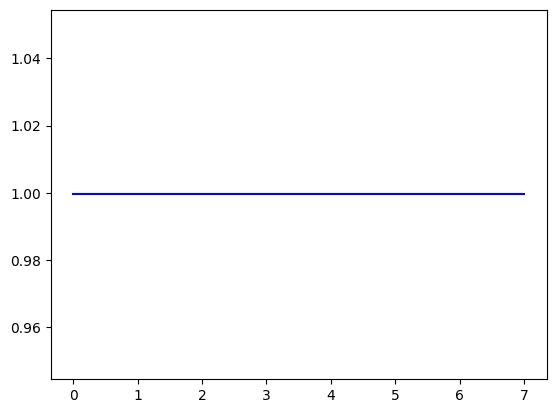

In [5]:
from LR import SSLR
import matplotlib.pyplot as plt

model = SSLR(devices, approx=False)
accs = model.fit(X_train, y_train, X_test, y_test, n_epochs=10, batch_size=1024, val_steps=10, lr=0.1)
plt.plot(accs,label = "SSLR",color = "blue")
